In [1]:
"""
In this lab, we'll go ahead and use the sklearn API to compare some real models over real data!
Same data as last time, for now.

Documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

We'll need to install sklearn, and numpy.
Use pip:

    # install everything from the requirements file.
    pip install -r requirements.txt
"""

# We won't be able to get past these import statments if you don't install the libraries!
# external libraries:
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# standard python
import json
from dataclasses import dataclass
from typing import Dict, Any, List

# helper functions I made
from shared import dataset_local_path, TODO

In [2]:
#%% load up the data
examples = []
ys = []

with open(dataset_local_path("poetry_id.jsonl")) as fp:
    for line in fp:
        info = json.loads(line)
        # Note: the data contains a whole bunch of extra stuff; we just want numeric features for now.
        keep = info["features"]
        # whether or not it's poetry is our label.
        ys.append(info["poetry"])
        # hold onto this single dictionary.
        examples.append(keep)

In [3]:
#%% Convert data to 'matrices'
# We did this manually in p02, but SciKit-Learn has a tool for that:

from sklearn.feature_extraction import DictVectorizer

feature_numbering = DictVectorizer(sort=True)
feature_numbering.fit(examples)
X = feature_numbering.transform(examples)

print("Features as {} matrix.".format(X.shape))
#%% Set up our ML problem:

from sklearn.model_selection import train_test_split

RANDOM_SEED = 12345678

# Numpy-arrays are more useful than python's lists.
y = np.array(ys)
# split off train/validate (tv) pieces.
X_tv, X_test, y_tv, y_test = train_test_split(
    X, y, train_size=0.75, shuffle=True, random_state=RANDOM_SEED
)
# split off train, validate from (tv) pieces.
X_train, X_vali, y_train, y_vali = train_test_split(
    X_tv, y_tv, train_size=0.66, shuffle=True, random_state=RANDOM_SEED
)

# In this lab, we'll ignore test data, for the most part.

Features as (2772, 38) matrix.


In [4]:
#%% DecisionTree Parameters:
params = {
    "criterion": "gini",
    "splitter": "best",
    "max_depth": 5,
}

# train 100 different models, with different sources of randomness:
N_MODELS = 100
# sample 1 of them 100 times, to get a distribution of data for that!
N_SAMPLES = 100

seed_based_accuracies = []
for randomness in range(N_MODELS):
    f_seed = DecisionTreeClassifier(random_state=RANDOM_SEED + randomness, **params)
    f_seed.fit(X_train, y_train)
    seed_based_accuracies.append(f_seed.score(X_vali, y_vali))


bootstrap_based_accuracies = []
# single seed, bootstrap-sampling of predictions:
f_single = DecisionTreeClassifier(random_state=RANDOM_SEED, **params)
f_single.fit(X_train, y_train)
y_pred = f_single.predict(X_vali)

# do the bootstrap:
for trial in range(N_SAMPLES):
    sample_pred, sample_truth = resample(
        y_pred, y_vali, random_state=trial + RANDOM_SEED
    )
    score = accuracy_score(y_true=sample_truth, y_pred=sample_pred)
    bootstrap_based_accuracies.append(score)

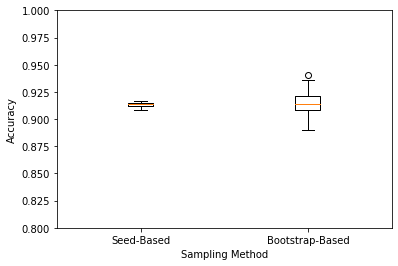

In [5]:
boxplot_data: List[List[float]] = [seed_based_accuracies, bootstrap_based_accuracies]
plt.boxplot(boxplot_data)
plt.xticks(ticks=[1, 2], labels=["Seed-Based", "Bootstrap-Based"])
plt.xlabel("Sampling Method")
plt.ylabel("Accuracy")
plt.ylim([0.8, 1.0])
plt.show()
# if plt.show is not working, try opening the result of plt.savefig instead!
# plt.savefig("dtree-variance.png") # This doesn't work well on repl.it.

### 1. understand/compare the bounds generated between the two methods.

The bounds of the bootsrap have more variance. There is more variety of accuracies from resampling than from changing the the random seed. 

### 2A. Evaluation++: what happens to the variance if we do K bootstrap samples for each of M models?

In [6]:
#%% DecisionTree Parameters:
params = {
    "criterion": "gini",
    "splitter": "best",
    "max_depth": 5,
}

# train 100 different models, with different sources of randomness:
N_MODELS = 100
# sample 1 of them 100 times, to get a distribution of data for that!
N_SAMPLES = 1000

seed_based_accuracies = []
for randomness in range(N_MODELS):
    f_seed = DecisionTreeClassifier(random_state=RANDOM_SEED + randomness, **params)
    f_seed.fit(X_train, y_train)
    seed_based_accuracies.append(f_seed.score(X_vali, y_vali))


bootstrap_based_accuracies = []
# single seed, bootstrap-sampling of predictions:
f_single = DecisionTreeClassifier(random_state=RANDOM_SEED, **params)
f_single.fit(X_train, y_train)
y_pred = f_single.predict(X_vali)

# do the bootstrap:
for trial in range(N_SAMPLES):
    sample_pred, sample_truth = resample(
        y_pred, y_vali, random_state=trial + RANDOM_SEED
    )
    score = accuracy_score(y_true=sample_truth, y_pred=sample_pred)
    bootstrap_based_accuracies.append(score)

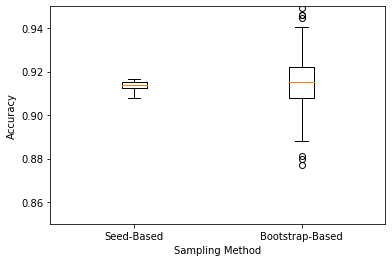

In [7]:
boxplot_data: List[List[float]] = [seed_based_accuracies, bootstrap_based_accuracies]
plt.boxplot(boxplot_data)
plt.xticks(ticks=[1, 2], labels=["Seed-Based", "Bootstrap-Based"])
plt.xlabel("Sampling Method")
plt.ylabel("Accuracy")
plt.ylim([0.85, 0.95])
plt.show()

compared to the k=100 and m = 100 (below) the k=1000 and m=100 (above) has a lot more variance which makes sense because we are taking a much larger sample 

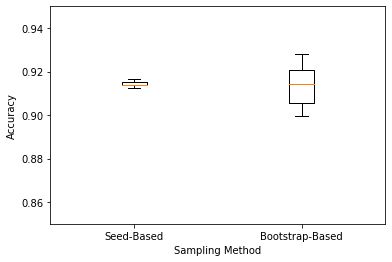

In [32]:
#don't run this
boxplot_data: List[List[float]] = [seed_based_accuracies, bootstrap_based_accuracies]
plt.boxplot(boxplot_data)
plt.xticks(ticks=[1, 2], labels=["Seed-Based", "Bootstrap-Based"])
plt.xlabel("Sampling Method")
plt.ylabel("Accuracy")
plt.ylim([0.85, 0.95])
plt.show()

####  2B. Return to experimenting on the decision tree: modify the plot to show ~10 max_depths of the decision tree

In [9]:
# train 100 different models, with different sources of randomness:
N_MODELS = 100
# sample 1 of them 100 times, to get a distribution of data for that!
N_SAMPLES = 100

depth_scores = {}
for i in range(1,10):
    params = {
    "criterion": "gini",
    "splitter": "best",
    "max_depth": i,
    }
    bootstrap_based_accuracies = []
    # single seed, bootstrap-sampling of predictions:
    f_single = DecisionTreeClassifier(random_state=RANDOM_SEED, **params)
    f_single.fit(X_train, y_train)
    y_pred = f_single.predict(X_vali)

    # do the bootstrap:
    for trial in range(N_SAMPLES):
        sample_pred, sample_truth = resample(
            y_pred, y_vali, random_state=trial + RANDOM_SEED
        )
        score = accuracy_score(y_true=sample_truth, y_pred=sample_pred)
        bootstrap_based_accuracies.append(score)
    depth_scores[i] = bootstrap_based_accuracies

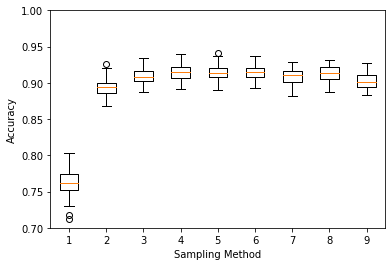

In [19]:
boxplot_data: List[List[float]] = depth_scores.values()
plt.boxplot(boxplot_data)
plt.xticks(ticks=range(1,10), labels=depth_scores.keys())
plt.xlabel("Sampling Method")
plt.ylabel("Accuracy")
plt.ylim([0.7, 1.0])
plt.show()